# Reliability scoring example for Win-Tie-Loss human evaluation

## Overall logic for Reliability scoring (REL)

REL can be seen as accuracy against a trusted annotation - **Subject Matter Expert (SME) or Quality Control (QC)**.  

From an annotator standpoint, we calculate all correct matches from their annotations against QC and compute the accuracy.  

Given that some annotations are hierarchical by definition - first annotators decide if a prompt can be rated, then perform annotation - there can be a mismatch between QC and annotator "matchability".  
For instance, if an annotator flags the prompt as NSFW, the annotator will not have the chance to select the best response. However, if QC does not flag as NSFW, QC will select a response and annotator will be penalized by incorrect response, even if the error was in the first level (flagging). Thus we need to calculate this error separately so there are no confounding factors.  
As an example, an annotator can perform poorly in NSFW flagging, but be extremely aligned with QC when selecting the best response. This annotator would then have low overall reliability if the first level (flagging) is not treated separately.

Below are some details about the logic.

#### Numerator

The numerator part of REL is straighforward. It is calculated as the total correct matches between annotator versus QC.

#### Denominator

As previously introduced, there are some adjustments (deductions) needed in the denominator part of REL, so that we do not overpenalize mistakes such as incorrect prompt flagging.

---

### **Why Adjust the Denominator?**
This part explains the logic and rationale behind **denominator deductions** in reliability calculations.

In reliability calculations, the denominator represents the **total number of opportunities to provide a correct annotation**. However, not all opportunities are valid. Adjusting the denominator excludes irrelevant or invalid cases, ensuring the metric reflects only meaningful data.

### **Reasons for Adjustments**
Below are somme examples that could be reasons to adjust the denominator.

1. **Invalid Prompts**:
   - If a prompt is flagged as not being suitable, such as requesting PII, medical advice or other reasons for being flagged, this prompt should not be considered for downstream annotation. In this example, the selection of best response.

2. **Skipped Cases**:
   - Cases marked as skipped by annotators or QCs indicate that there could be an error or undefined edge-case during annotation, such as non-rendered Markdown, unexpected language, etc.
       - This is a very conservative approach.
       - This case will not be addressed in this example.

3. **No Consensus**:
   - For consensus-based evaluations, cases without consensus are unsuitable for reliability calculations. E.g. for binary ranking, if annotators say `[A,B,Tie]` there's no consensus.
      - This case will not be addressed in this example.


## Steps

Importing relevant libraries

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

In case you have your data in a json file, you can load it with the following code:

In [2]:
#data_path = 'your_file_here.json'
#with open(data_path, 'r') as f:
#    data = json.load(f)

Here we are going to use a toy sample of data to test the code:

In [3]:
data = [{"output_values": {"13612529": {"item_flag": "No", "best": "tie"}, "48728677": {"item_flag": "No", "best": "response_1"}, "80596315": {"item_flag": "No", "best": "response_2"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "tie"}, "48728677": {"item_flag": "No", "best": "response_1"}, "80596315": {"item_flag": "No", "best": "tie"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_1"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_1"}, "48728677": {"item_flag": "No", "best": "response_1"}, "80596315": {"item_flag": "No", "best": "response_1"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_1"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_1"}, "48728677": {"item_flag": "No", "best": "response_1"}, "83438993": {"item_flag": "No", "best": "response_1"}}, "QC": {"97242374": {"item_flag": "No", "best": "response_1"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "tie"}, "48728677": {"item_flag": "No", "best": "response_1"}, "80596315": {"item_flag": "No", "best": "response_1"}}, "QC": {"39418189": {"item_flag": "No", "best": "tie"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_2"}, "48728677": {"item_flag": "No", "best": "response_1"}, "83438993": {"item_flag": "No", "best": "response_1"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_2"}, "48728677": {"item_flag": "No", "best": "response_2"}, "80596315": {"item_flag": "No", "best": "response_2"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_2"}, "48728677": {"item_flag": "No", "best": "response_1"}, "80596315": {"item_flag": "No", "best": "response_1"}}, "QC": {"84961759": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_1"}, "48728677": {"item_flag": "No", "best": "response_2"}, "80596315": {"item_flag": "No", "best": "response_2"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"13612529": {"item_flag": "No", "best": "response_1"}, "48728677": {"item_flag": "No", "best": "tie"}, "80596315": {"item_flag": "No", "best": "tie"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_1"}}},
{"output_values": {"32829317": {"item_flag": "No", "best": "tie"}, "83438993": {"item_flag": "No", "best": "response_1"}, "96639812": {"item_flag": "No", "best": "response_1"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_1"}}},
{"output_values": {"32829317": {"item_flag": "No", "best": "response_2"}, "83438993": {"item_flag": "No", "best": "response_2"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"39418189": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"32829317": {"item_flag": "No", "best": "response_2"}, "83438993": {"item_flag": "No", "best": "response_2"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"97242374": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"32829317": {"item_flag": "No", "best": "response_2"}, "83438993": {"item_flag": "No", "best": "response_2"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"97242374": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"87945218": {"item_flag": "No", "best": "response_2"}, "49457445": {"item_flag": "No", "best": "response_2"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"84961759": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"87945218": {"item_flag": "No", "best": "response_1"}, "21985388": {"item_flag": "No", "best": "response_1"}, "96639812": {"item_flag": "No", "best": "tie"}}, "QC": {"84961759": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"87945218": {"item_flag": "No", "best": "response_2"}, "21985388": {"item_flag": "No", "best": "response_1"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"84961759": {"item_flag": "No", "best": "response_2"}}},
{"output_values": {"87945218": {"item_flag": "No", "best": "response_1"}, "21985388": {"item_flag": "No", "best": "response_1"}, "96639812": {"item_flag": "No", "best": "response_2"}}, "QC": {"84961759": {"item_flag": "No", "best": "response_2"}}}]

### Computing the metrics for Reliability

Here we are going to define the function that computes the metrics for Reliability.
The main goal is to compute the following metrics for each evaluator:
- Reliability: Fraction of applicable items (both QC and evaluator have "item_flag" == "No")
  where evaluator’s choice equals QC’s choice.
- Flag Mismatch %: Percentage of items where evaluator's "item_flag" differs from QC's "item_flag".
  Here "item_flag" refers to the case where item is flagged as NSFW
- Total Items: Total number of items evaluated.


In [4]:
def compute_metrics_for_plot(data):
    """
    Processes multiple items and computes, for each evaluator:
      - Reliability: Fraction of applicable items (both QC and evaluator have "item_flag" == "No")
        where evaluator’s choice equals QC’s choice.
      - Flag Mismatch %: Percentage of items where evaluator's "item_flag" differs from QC's "item_flag".
        Here "item_flag" refers to the case where item is flagged as NSFW
      - Total Items: Total number of items evaluated.
    
    Also computes overall metrics:
      - Overall QC 'Yes' Percentage (across all items).
      - Overall Reliability (aggregated across evaluator responses).
      - Overall Flag Mismatch % (aggregated over all evaluators).
      - Overall Total Items (sum of evaluator items).
    
    Returns:
      - df: A DataFrame with evaluator IDs as the index (plus an extra "Overall" row) and columns:
            "Reliability", "Flag Mismatch %", "Total Items".
      - qc_yes_percentage: Overall percentage of items where QC's "item_flag" is "Yes".
      - overall_accuracy: Overall reliability aggregated across evaluators.
    """
    evaluator_metrics = {}
    total_items = 0
    qc_yes_count_global = 0
    overall_best_correct = 0
    overall_best_total = 0

    for item in data:
        total_items += 1
        
        # Extract the QC judgment (assumes one key in the QC dict)
        qc_judgment = list(item["QC"].values())[0]
        qc_flag = qc_judgment.get("item_flag")
        qc_best = qc_judgment.get("best")
        
        if qc_flag == "Yes": # Here if an item is "flagged" it means that item is unratable or NSFW
            qc_yes_count_global += 1

        # Process each evaluator's response in the item
        for evaluator_id, eval_judgment in item["output_values"].items():
            if evaluator_id not in evaluator_metrics:
                evaluator_metrics[evaluator_id] = {
                    "best_total": 0,    # Count of applicable items for best comparison
                    "best_correct": 0,  # Count where evaluator's best equals QC's best
                    "flag_mismatch": 0, # Count of items with item_flag mismatch
                    "total_items": 0    # Total items evaluated by this evaluator
                }
            evaluator_metrics[evaluator_id]["total_items"] += 1

            evaluator_flag = eval_judgment.get("item_flag")
            evaluator_best = eval_judgment.get("best")
            
            # Count mismatch in item_flag between evaluator and QC
            if evaluator_flag != qc_flag:
                evaluator_metrics[evaluator_id]["flag_mismatch"] += 1

            # Only compare "best" when both QC and evaluator have "item_flag" == "No"
            if qc_flag == "No" and evaluator_flag == "No":
                evaluator_metrics[evaluator_id]["best_total"] += 1
                if evaluator_best == qc_best:
                    evaluator_metrics[evaluator_id]["best_correct"] += 1

    result = {}
    total_eval_items = 0
    total_flag_mismatch = 0
    for evaluator_id, metrics in evaluator_metrics.items():
        total = metrics["total_items"]
        total_eval_items += total
        flag_mismatch_percentage = (metrics["flag_mismatch"] / total) * 100 if total > 0 else None
        best_accuracy = (metrics["best_correct"] / metrics["best_total"]) if metrics["best_total"] > 0 else None
        
        # Aggregate for overall reliability
        overall_best_correct += metrics["best_correct"]
        overall_best_total += metrics["best_total"]
        total_flag_mismatch += metrics["flag_mismatch"]
        
        result[evaluator_id] = {
            "Reliability": best_accuracy,
            "Flag Mismatch %": flag_mismatch_percentage,
            "Total Items": total
        }
        
    df = pd.DataFrame.from_dict(result, orient='index')
    qc_yes_percentage = (qc_yes_count_global / total_items) * 100 if total_items > 0 else None
    overall_accuracy = overall_best_correct / overall_best_total if overall_best_total > 0 else None
    overall_flag_mismatch_pct = (total_flag_mismatch / total_eval_items) * 100 if total_eval_items > 0 else None

    # Create an "Overall" row
    overall_row = {
        "Reliability": overall_accuracy,
        "Flag Mismatch %": overall_flag_mismatch_pct,
        "Total Items": total_eval_items
    }
    # Append the overall row to the DataFrame
    df.loc["Overall"] = overall_row

    return df, qc_yes_percentage, overall_accuracy




### Generating the matrix plot for better visualization

Here we are going to define the function that generates the matrix plot using the dataframe resulting from the compute_metrics_for_plot function.

In [5]:
def plot_metrics(df):
    """
    Creates a matrix plot (colored table) from the Reliability DataFrame.
    - "Reliability": colored from red (low) to green (high).
    - "Flag Mismatch %": colored from green (low) to red (high).
    - "Total Items": not colored.
    """
    fig, ax = plt.subplots(figsize=(8, len(df)*0.3 + 0))
    ax.axis('off')  # Hide axes

    table = ax.table(cellText=df.values,
                     rowLabels=df.index,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='center')
    
    # Colormap for Reliability: higher is better → green; lower → red.
    cmap_accuracy = plt.cm.RdYlGn
    norm_accuracy = mcolors.Normalize(vmin=0, vmax=1)
    
    # Colormap for Flag Mismatch %: lower is better → green; higher → red.
    cmap_mismatch = plt.cm.RdYlGn_r
    norm_mismatch = mcolors.Normalize(vmin=0, vmax=100)
    
    # Loop over table cells to set background colors.
    for (row, col), cell in table.get_celld().items():
        # Skip header row and row labels.
        if row == 0 or col == -1:
            continue
        col_name = df.columns[col]
        value = df.iloc[row-1, col]
        if col_name == "Reliability":
            if pd.notnull(value):
                color = cmap_accuracy(norm_accuracy(value))
                cell.set_facecolor(color)
                cell.get_text().set_text(f"{value*100:.0f}%")
            else:
                cell.set_facecolor("white")
                cell.get_text().set_text("N/A")
        elif col_name == "Flag Mismatch %":
            if pd.notnull(value):
                color = cmap_mismatch(norm_mismatch(value))
                cell.set_facecolor(color)
                cell.get_text().set_text(f"{value:.0f}%")
            else:
                cell.set_facecolor("white")
                cell.get_text().set_text("N/A")
        elif col_name == "Total Items":
            # Do not color the "Total Items" column.
            cell.set_facecolor("white")
    
    plt.tight_layout()
    plt.show()


### Putting all together
Here we are going to put all the functions together and compute the metrics and generate the matrix plot.


In [6]:
df, qc_yes_percentage, overall_accuracy = compute_metrics_for_plot(data)

In [7]:
print(f"Overall prompts flagged as non-ratable (NSFW) by QC: {qc_yes_percentage:.2f}%")

Overall prompts flagged as non-ratable (NSFW) by QC: 0.00%


In [8]:
print(f"Overall Reliability across all evaluators: {overall_accuracy*100:.2f}%")

Overall Reliability across all evaluators: 62.96%


Here is the plot showing the reliability of each evaluator, the percentage disagreement between evaluators and QC in the ratability of the prompts, and the total number of prompts evaluated by each evaluator.

**It is extremely important to always check the scores having the total items evaluated by each evaluator in mind.**  
Evaluators with low number of total items might have high reliability scores just by chance.

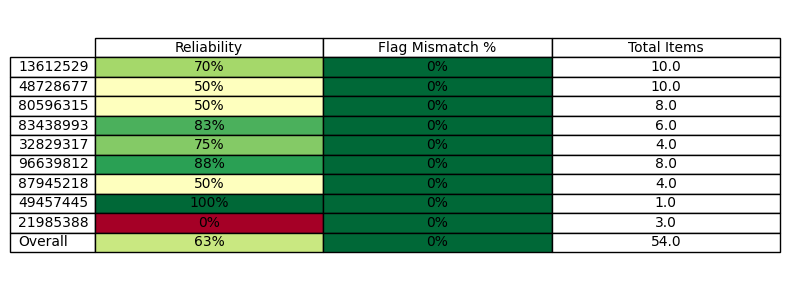

In [9]:
plot_metrics(df)